In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
from matplotlib.colors import ListedColormap

plt.style.use(['science', 'grid'])
plt.rc('figure', titlesize = 33, figsize = (21, 7))
plt.rc('axes', titlesize = 27, labelsize = 21, titlepad = 21)
plt.rc('xtick', labelsize = 17)
plt.rc('ytick', labelsize = 17)


In [3]:
# load data
import pickle

with open('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/classified/accepted.pkl', 'rb') as f:
    extracted = pickle.load(f)

## data preprocessing

In [5]:
extracted[0].keys()

dict_keys(['trial', 'notes', 'events', 'data', 'event_mean', 'event_std', 'positive peaks', 'negative peaks'])

In [4]:
features = []
sessions = []
for session in extracted:
    data = session['event_mean'][:, 300:450]

    # Retrieve the peaks; they might be None or empty lists.
    positive_peaks = session.get('positive peaks')
    negative_peaks = session.get('negative peaks')

    # Check for positive peaks and extract the first one if available.
    if positive_peaks and len(positive_peaks) > 0:
        delay_pos, amplitude_pos = sorted(positive_peaks, key=lambda x: x[0])[0]
    else:
        delay_pos, amplitude_pos = np.nan, np.nan

    # Check for negative peaks and extract the first one if available.
    if negative_peaks and len(negative_peaks) > 0:
        delay_neg, amplitude_neg = sorted(negative_peaks, key=lambda x: x[0])[0]
    else:
        delay_neg, amplitude_neg = np.nan, np.nan

    # Calculate derived features only if both peaks exist.
    if not np.isnan(delay_pos) and not np.isnan(delay_neg):
        com = (delay_pos + delay_neg) / 2
        width = abs(delay_pos - delay_neg)
        energy = (width / 2) * (amplitude_pos**2 + amplitude_neg**2)
    else:
        com = np.nan
        width = np.nan
        energy = np.nan

    # Append session info.
    temp = {
        'data': data,
        'label': 0 if session['notes']['phenoCode'] == 1.0 else 1,
        'stim': session['notes']['sessionType']
    }
    sessions.append(temp)

    # Create a Series with the computed features.
    series = pd.Series({
        'stim': session['notes']['sessionType'],
        'delay_pos': delay_pos,
        'delay_neg': delay_neg,
        'amplitude_pos': amplitude_pos,
        'amplitude_neg': np.abs(amplitude_neg) if not np.isnan(amplitude_neg) else np.nan,
        'com': com,
        'width': width,
        'energy': energy,
        'label': False if session['notes']['phenoCode'] == 1.0 else True
    })
    features.append(series)
    
# timeseries data
X_sciatic = np.array([session['data'] for session in sessions if session['stim'] == 'sciatic'])
y_sciatic = np.array([session['label'] for session in sessions if session['stim'] == 'sciatic'])
X_spine = np.array([session['data'] for session in sessions if session['stim'] == 'spine_hump'])
y_spine = np.array([session['label'] for session in sessions if session['stim'] == 'spine_hump'])

# feature dataframe
df = pd.DataFrame(features)
df = df.dropna()

df.to_csv('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MEP_features.csv', index=False)

df.head()


,stim,delay_pos,delay_neg,amplitude_pos,amplitude_neg,com,width,energy,label
0,sciatic,349.0,355.0,118.989561,77.492632,352.0,6.0,60490.870484,True
1,sciatic,348.0,354.0,124.166332,43.884565,351.0,6.0,52029.399127,True
2,spine_hump,401.0,391.0,56.792032,47.804081,396.0,10.0,27552.825067,True
3,spine_hump,422.0,389.0,40.191163,83.640463,405.5,33.0,142082.433561,True
4,sciatic,361.0,365.0,98.866950,124.666272,363.0,4.0,50632.706471,True


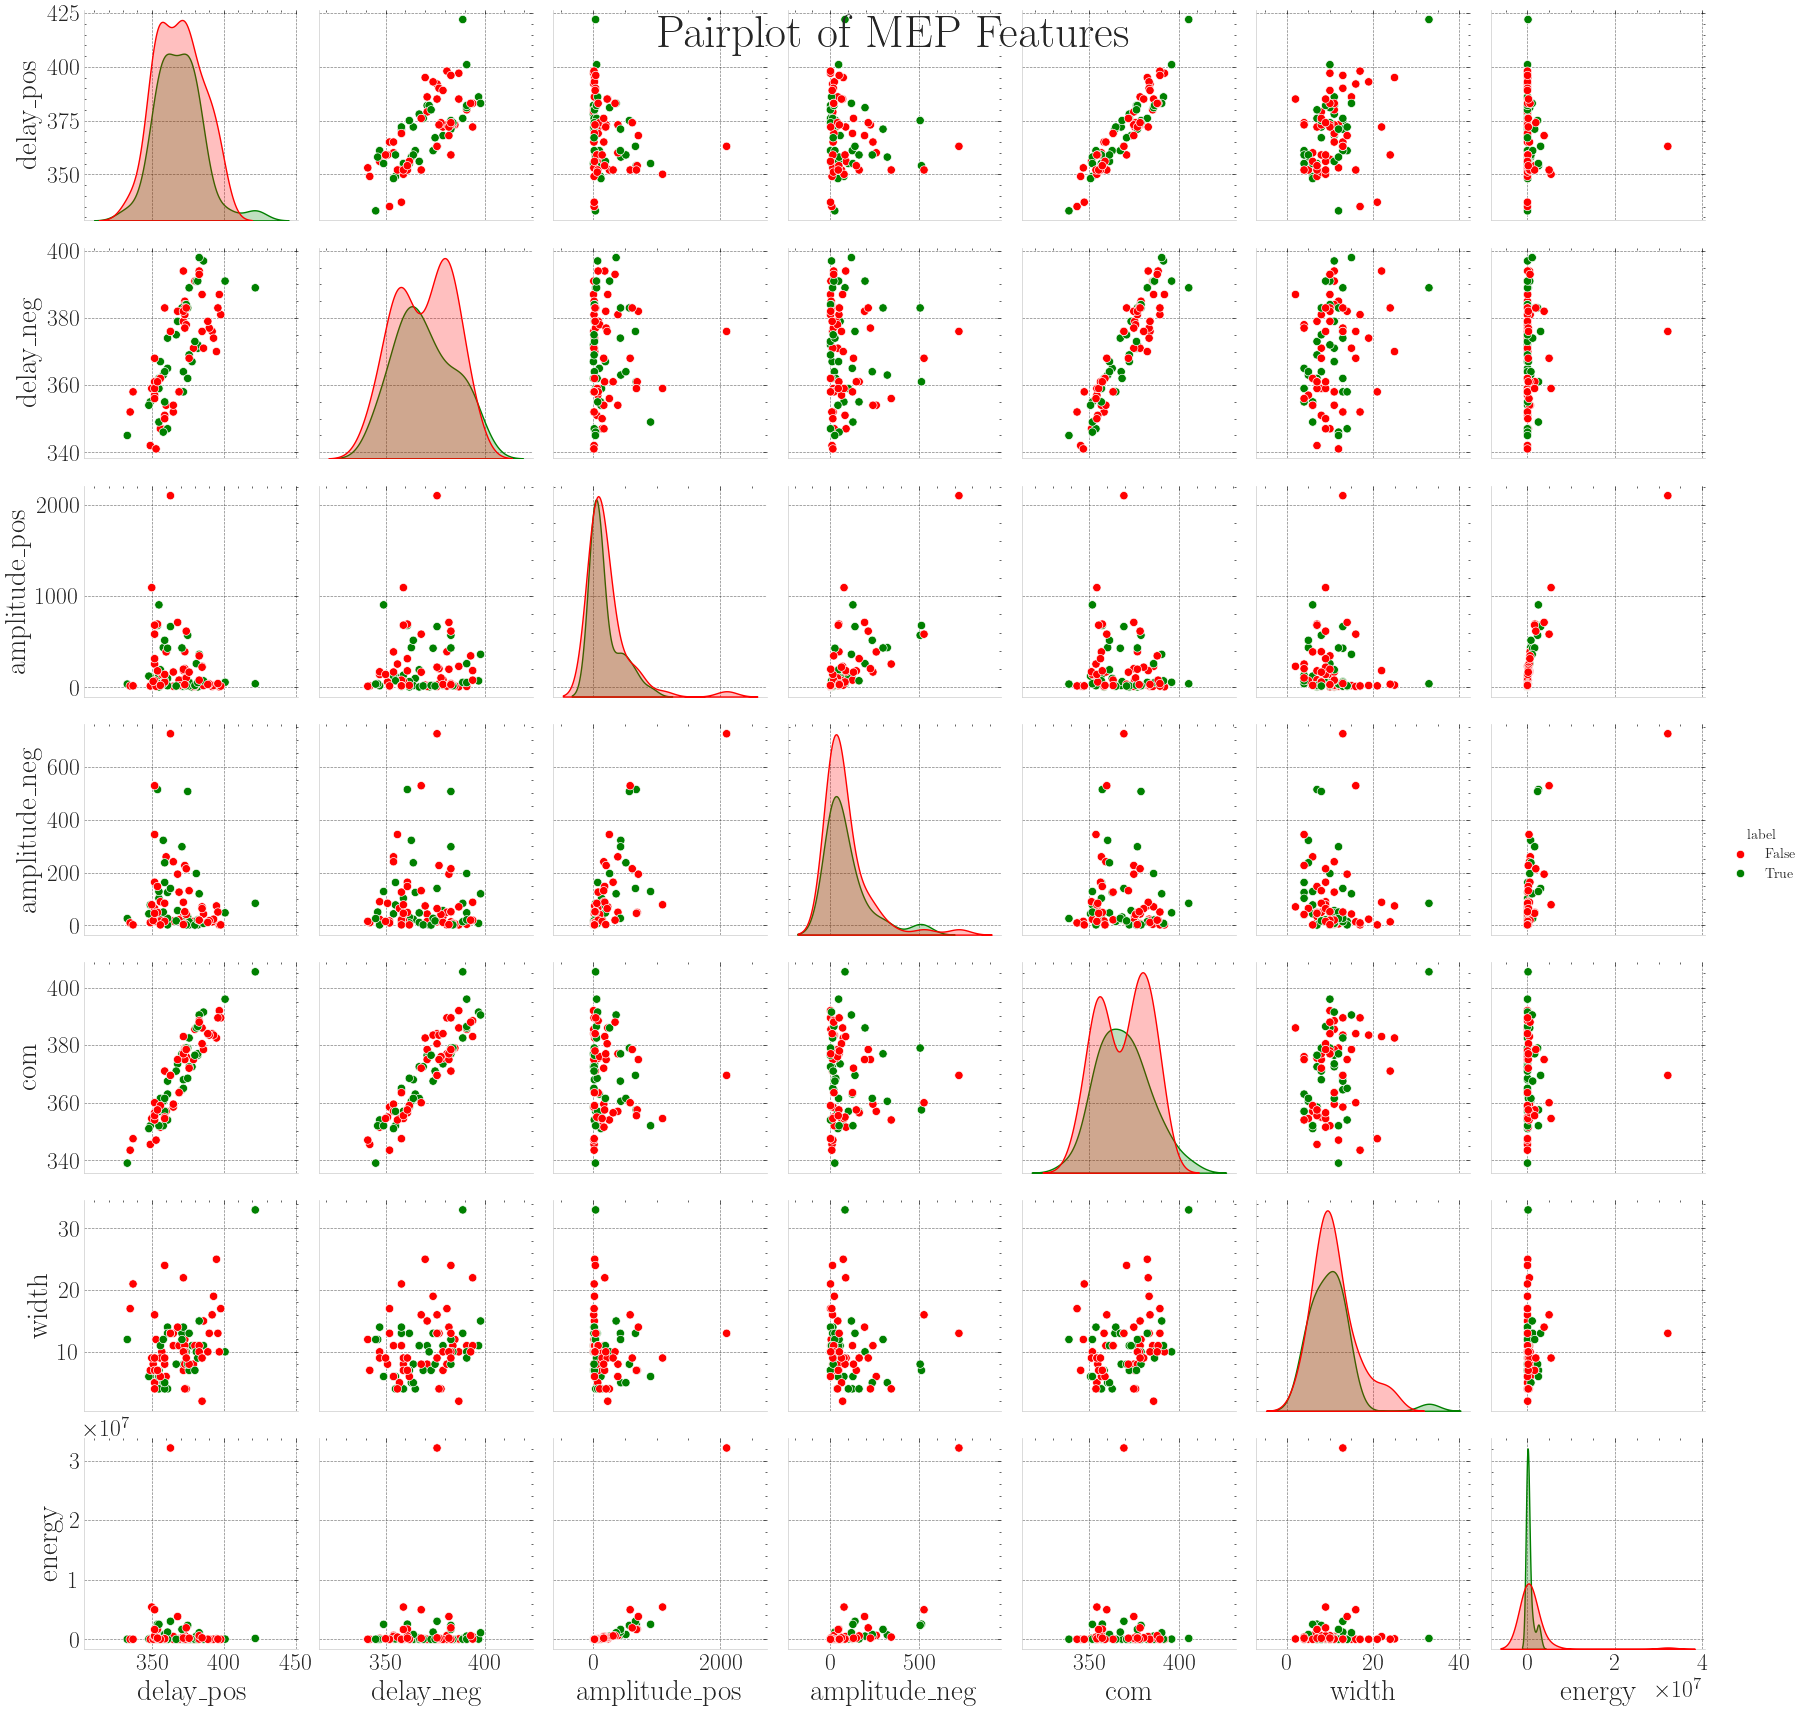

In [16]:
sns.pairplot(df, hue='label', palette=['red', 'green'])
plt.suptitle('Pairplot of MEP Features')
plt.show()


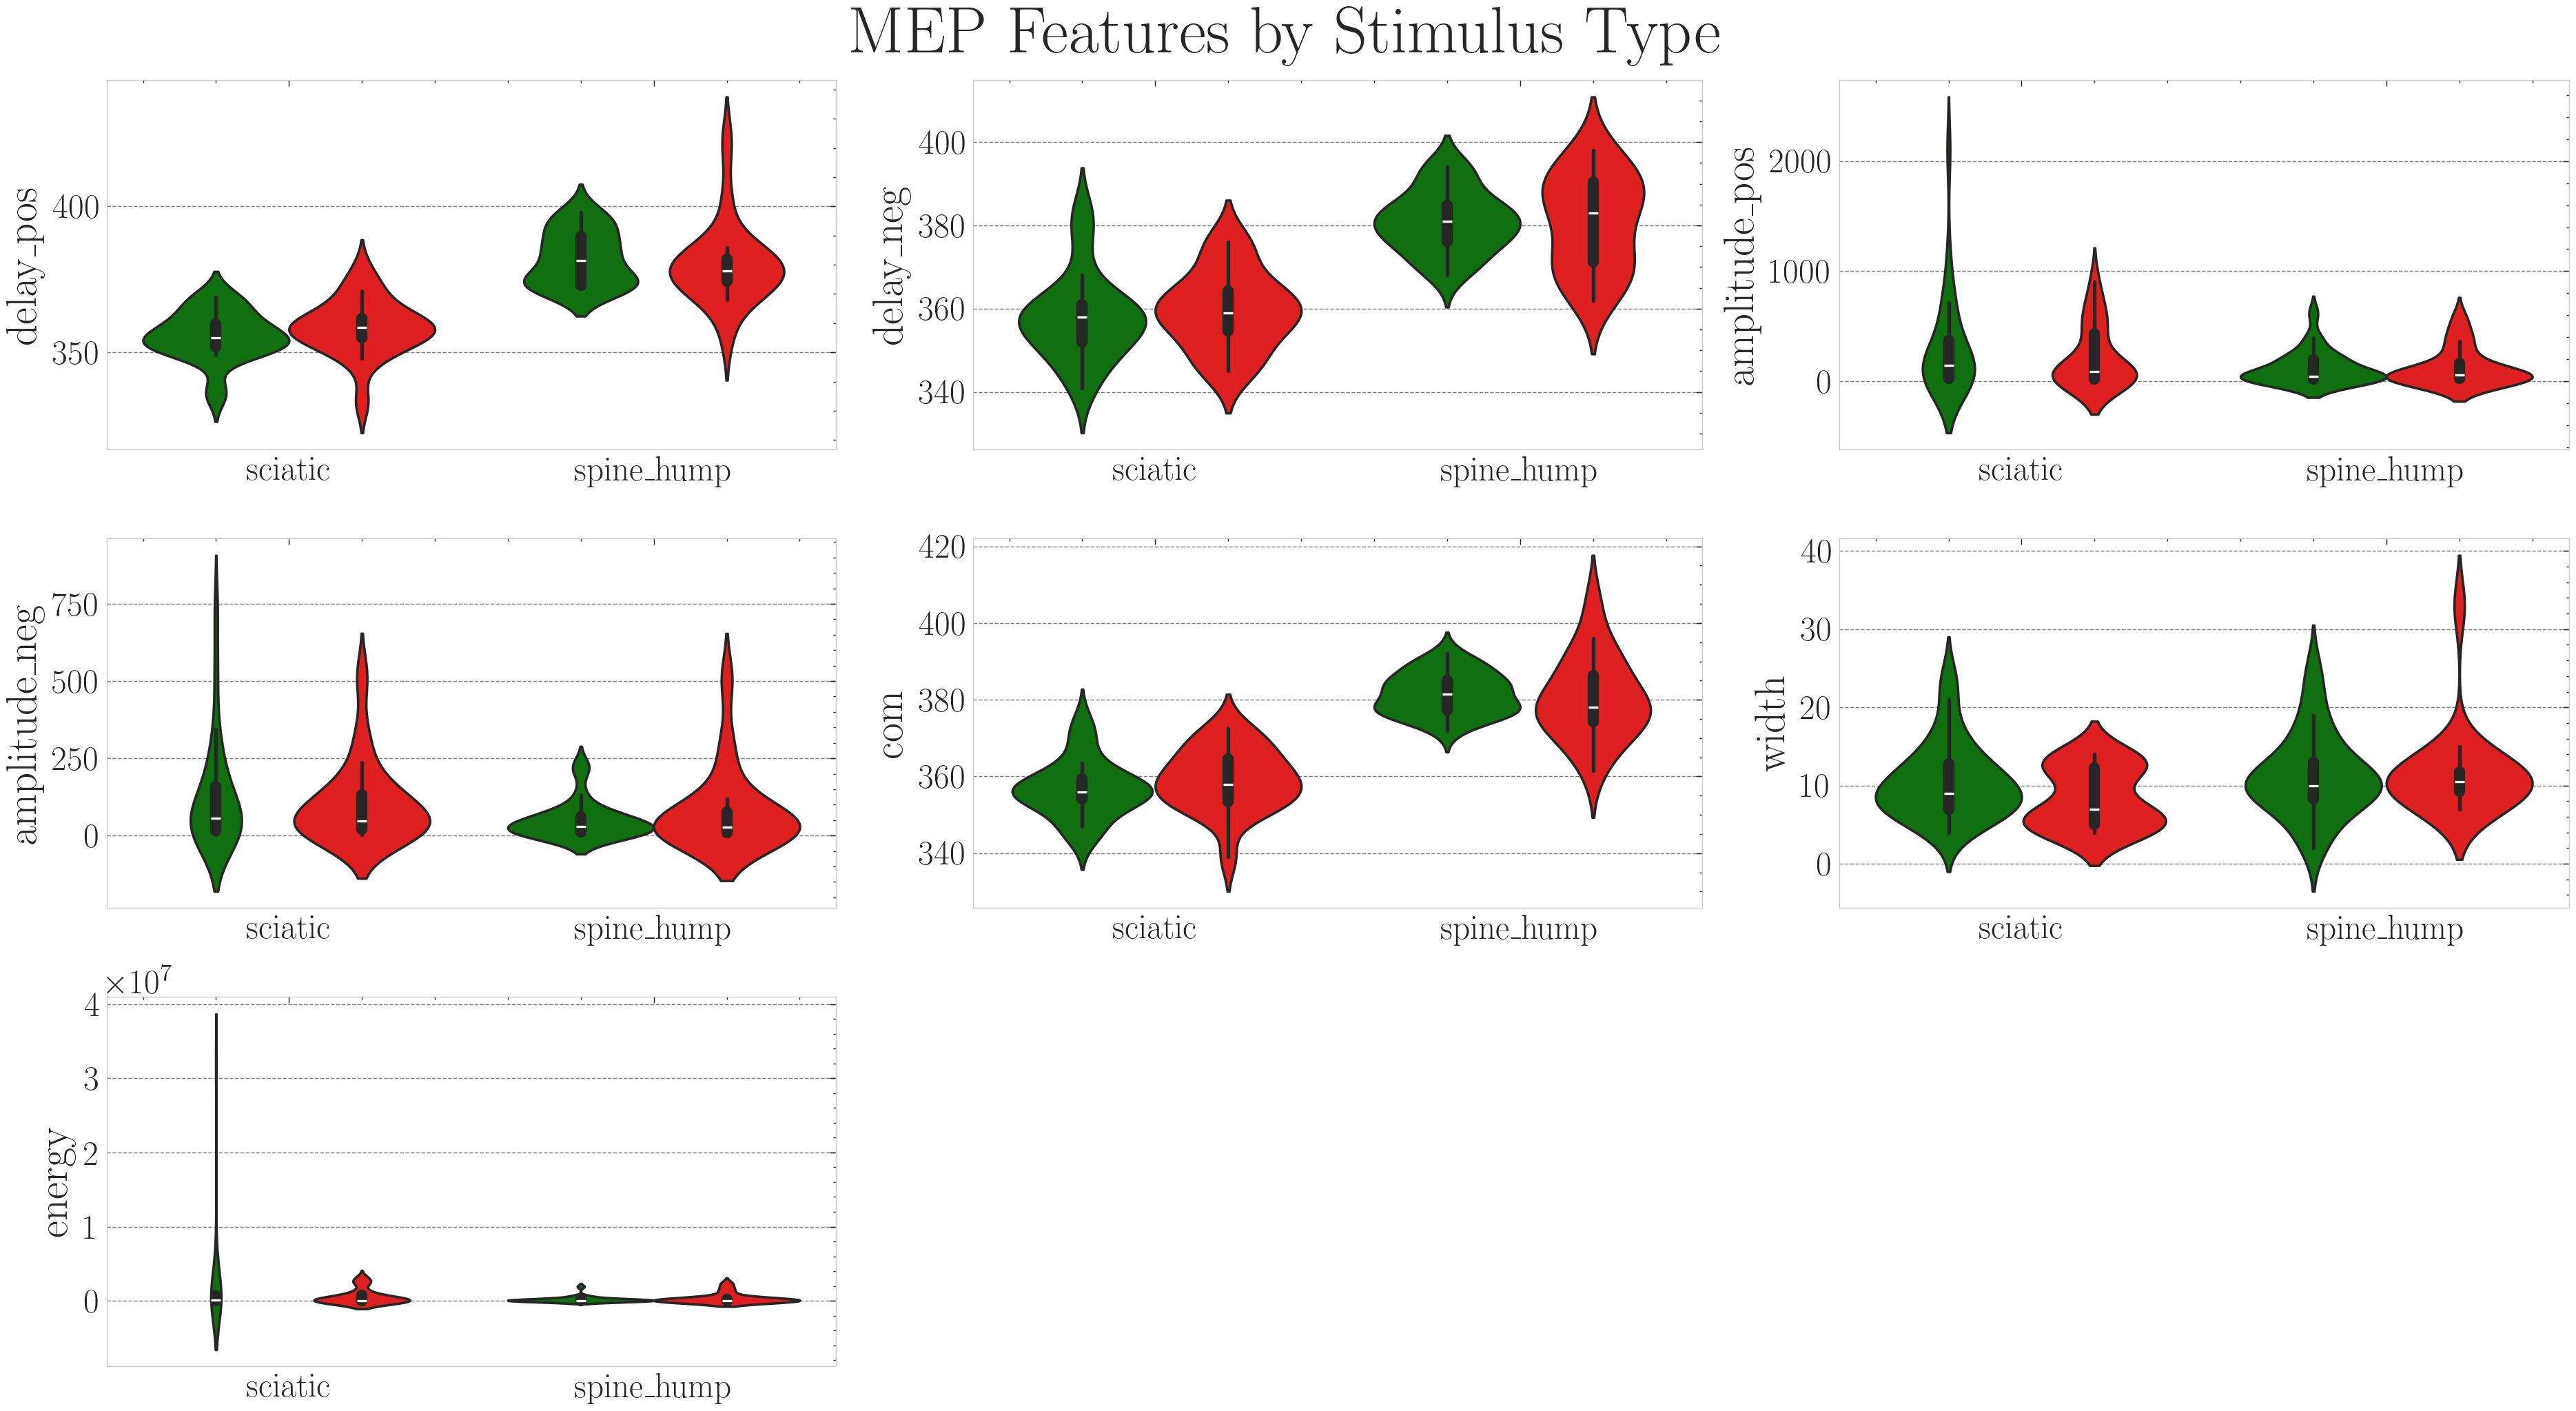

In [30]:
num_features = ["delay_pos", "delay_neg", "amplitude_pos", "amplitude_neg", "com", "width", "energy"]

plt.figure(figsize=(18, 10), dpi = 210)
for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=df, x="stim", y=feature, hue = "label", palette = ["green", "red"], legend = False)
    plt.xlabel('')  
plt.suptitle('MEP Features by Stimulus Type')
plt.tight_layout()
plt.show()

## PCA Visualisation

### PCA of Event Features by Stimulus Type


(sciatic, 1) Centroid Distance: 0.5250961275298573
(sciatic, 1) Average WT Spread PC1: 1.6861
(sciatic, 1) Average Mutant Spread PC1: 1.3138

(sciatic, 1) Average WT Spread PC2: 0.7806
(sciatic, 1) Average Mutant Spread PC2: 0.5911

(spine_hump, 2) Centroid Distance: 0.42566953957234815
(spine_hump, 2) Average WT Spread PC1: 1.1769
(spine_hump, 2) Average Mutant Spread PC1: 2.1065

(spine_hump, 2) Average WT Spread PC2: 0.7557
(spine_hump, 2) Average Mutant Spread PC2: 1.1143


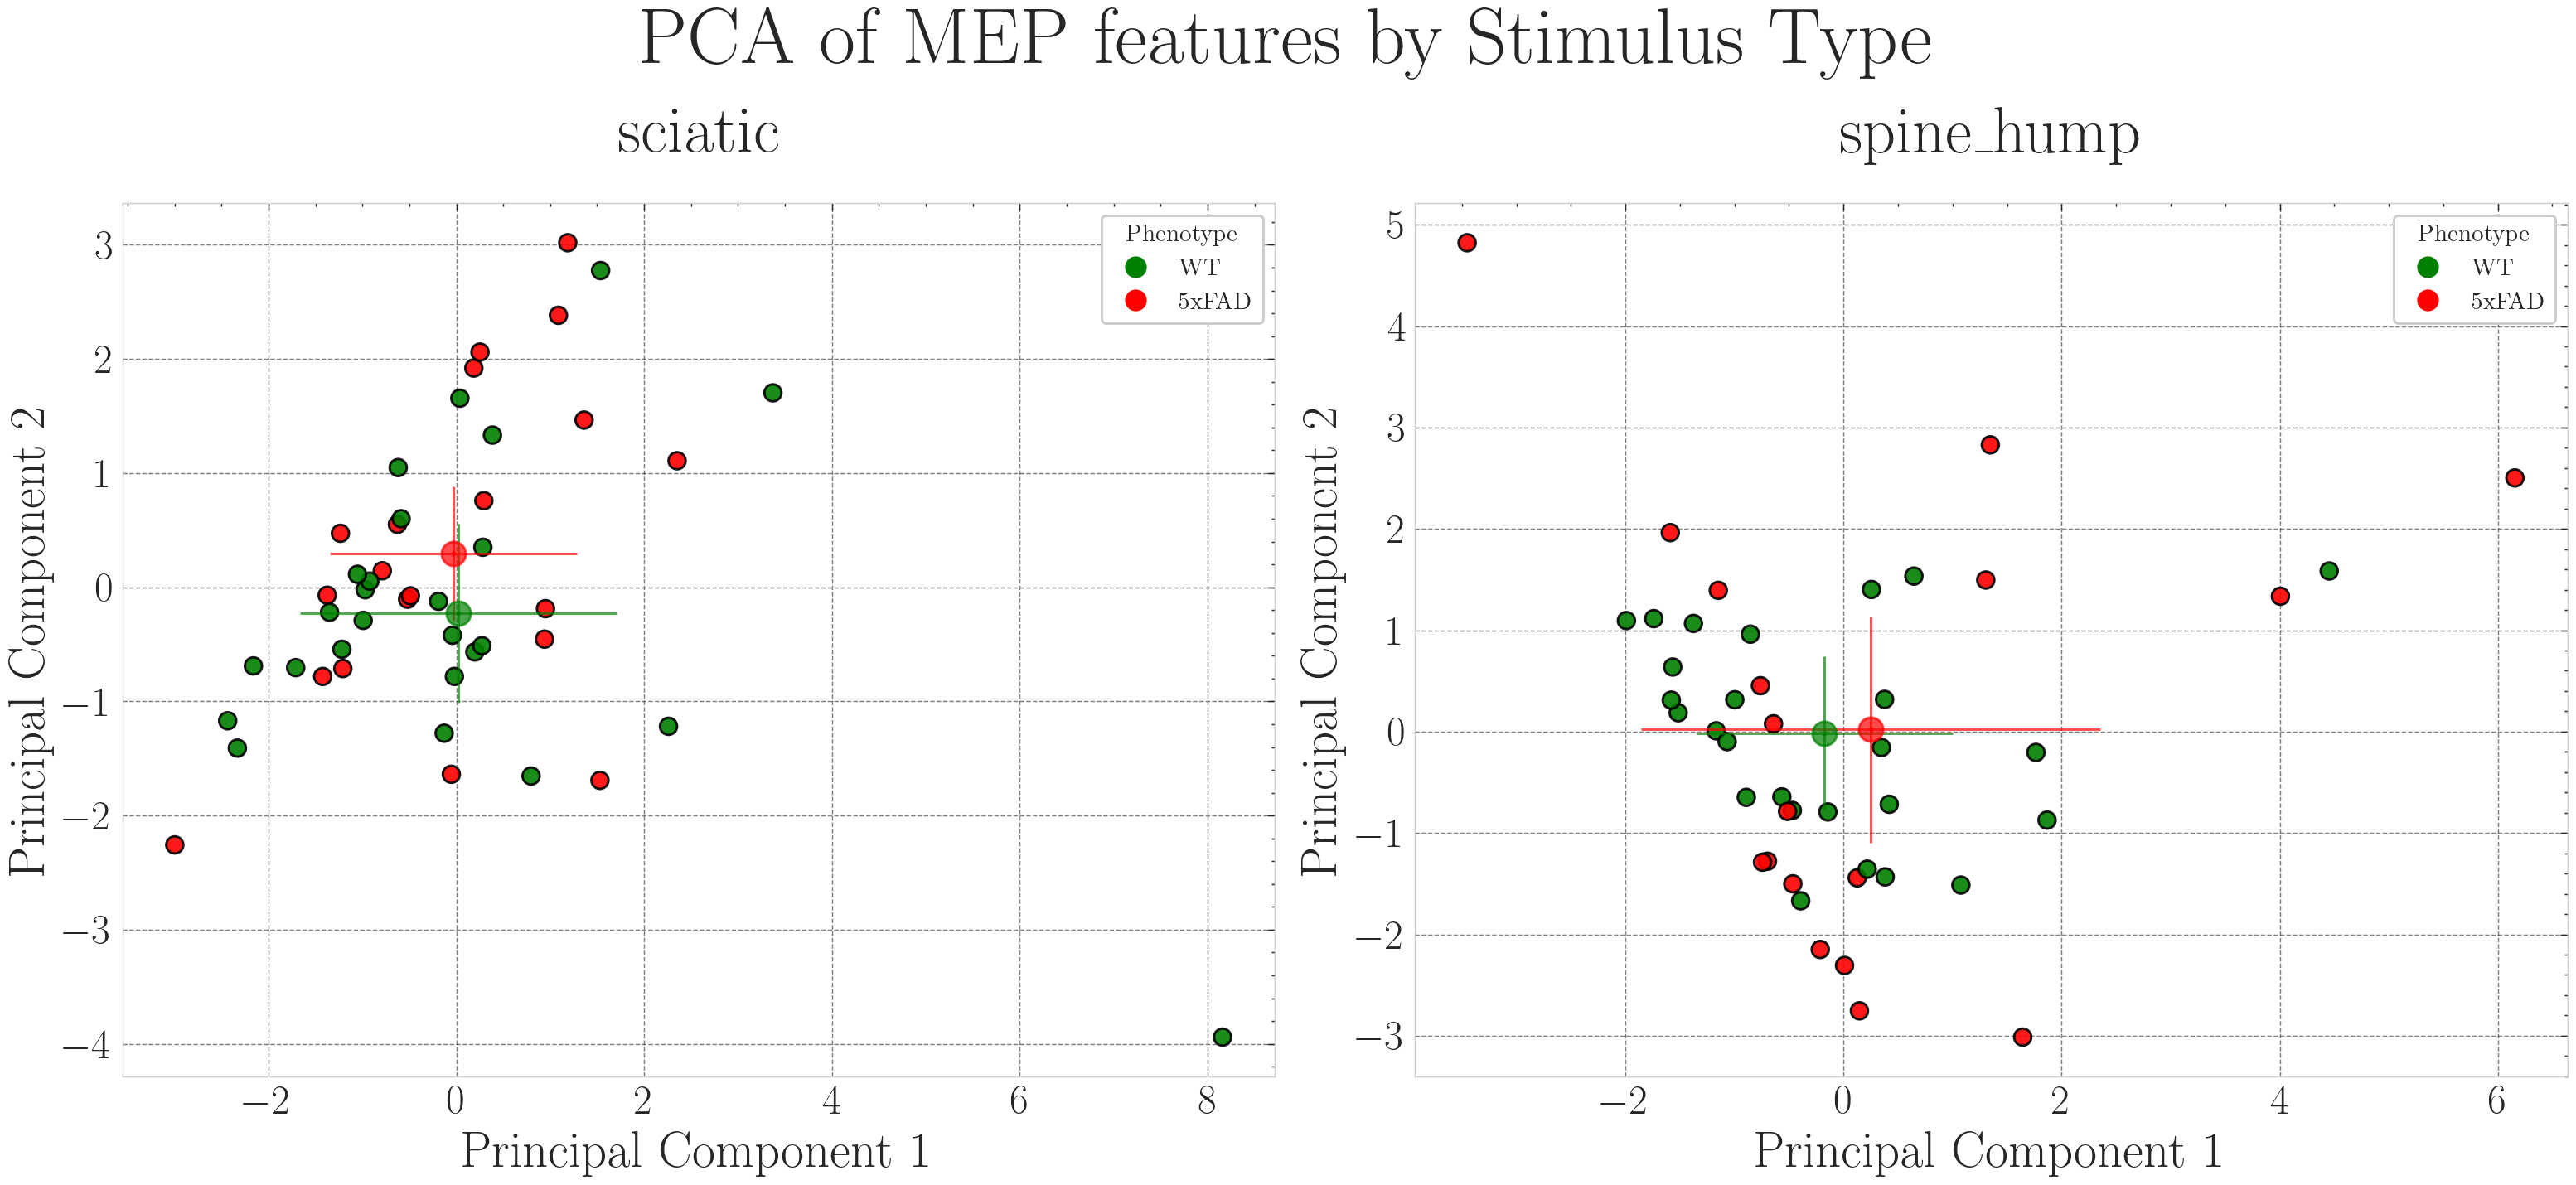

(<Figure size 3150x1470 with 2 Axes>,
 array([<Axes: title={'center': 'sciatic'}, xlabel='Principal Component 1', ylabel='Principal Component 2'>,
        <Axes: title={'center': 'spine_hump'}, xlabel='Principal Component 1', ylabel='Principal Component 2'>],
       dtype=object))

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors

colors = matplotlib.colors.ListedColormap(['green', 'red'])
phenotypes = {0: 'WT', 1: '5xFAD'}

def get_feature_pca(df, stim_types):
    n = len(stim_types)
    fig, ax = plt.subplots(1, n, figsize=(7*n + 1, 7), dpi=210)
    for i, stim_type in enumerate(stim_types):
        # split the data
        X = df[df['stim'] == stim_type].drop(columns=['stim', 'label'])
        y = df[df['stim'] == stim_type]['label']

        # scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA(n_components=2, random_state=343)
        X_pca = pca.fit_transform(X_scaled)
        
        # plot the PCA
        ax[i].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap = colors, edgecolor='k', s=50, alpha = 0.9)
        ax[i].set_xlabel('Principal Component 1')
        ax[i].set_ylabel('Principal Component 2')
        ax[i].set_title(f'{stim_type}')

        handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                              markerfacecolor=colors(i), label=phenotypes[i]) for i in phenotypes]
        ax[i].legend(handles=handles, title="Phenotype")
        
        # calculate centroids
        # calculate centroids
        wt_centroid = np.array([X_pca[y == 0].mean(axis=0)])
        mutant_centroid = np.array([X_pca[y == 1].mean(axis=0)])

        ax[i].plot(wt_centroid[:, 0], wt_centroid[:, 1], 'o', color='green', markersize=1, label='WT Centroid', alpha = 0.7)
        ax[i].plot(mutant_centroid[:, 0], mutant_centroid[:, 1], 'o', color='red', markersize=1, label='Mutant Centroid', alpha = 0.7)

        # euclidean distance between centroids (for two groups)
        centroid_distance = np.linalg.norm(wt_centroid - mutant_centroid)
        print(f"({stim_type}, {i + 1}) Centroid Distance:", centroid_distance)

        # Calculate average within-cluster standard deviation (spread)
        wt_std = [np.std(X_pca[y == 0], axis=0).mean(), np.std(X_pca[y == 0], axis=1).mean()]
        mutant_std = [np.std(X_pca[y == 1], axis=0).mean(), np.std(X_pca[y == 1], axis=1).mean()]

        ax[i].errorbar(wt_centroid[:, 0], wt_centroid[:, 1],
                             xerr=wt_std[0], yerr=wt_std[1],
                             fmt='o', color='green', markersize=10,
                             label='WT Centroid ± SD', alpha=0.7)

        ax[i].errorbar(mutant_centroid[:, 0], mutant_centroid[:, 1],
                             xerr=mutant_std[0], yerr=mutant_std[1],
                             fmt='o', color='red', markersize=10,
                             label='Mutant Centroid ± SD', alpha=0.7)


        print(f"({stim_type}, {i + 1}) Average WT Spread PC1: {wt_std[0]:.4f}")
        print(f"({stim_type}, {i + 1}) Average Mutant Spread PC1: {mutant_std[0]:.4f}\n")

        print(f"({stim_type}, {i + 1}) Average WT Spread PC2: {wt_std[1]:.4f}")
        print(f"({stim_type}, {i + 1}) Average Mutant Spread PC2: {mutant_std[1]:.4f}")
        
        
    
    plt.suptitle('PCA of MEP features by Stimulus Type')
    plt.tight_layout()
    plt.savefig('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/graphs/2D feature PCA.png')
    plt.show()

    return fig, ax

get_feature_pca(df, ['sciatic', 'spine_hump'])

### PCA of Timeseries


(Sciatic, Centroid Distance: 3.793990026247894
(Sciatic, Average WT Spread PC1: 9.3242
(Sciatic, Average Mutant Spread PC1: 7.3927

(Sciatic, Average WT Spread PC2: 4.7486
(Sciatic, Average Mutant Spread PC2: 5.6643


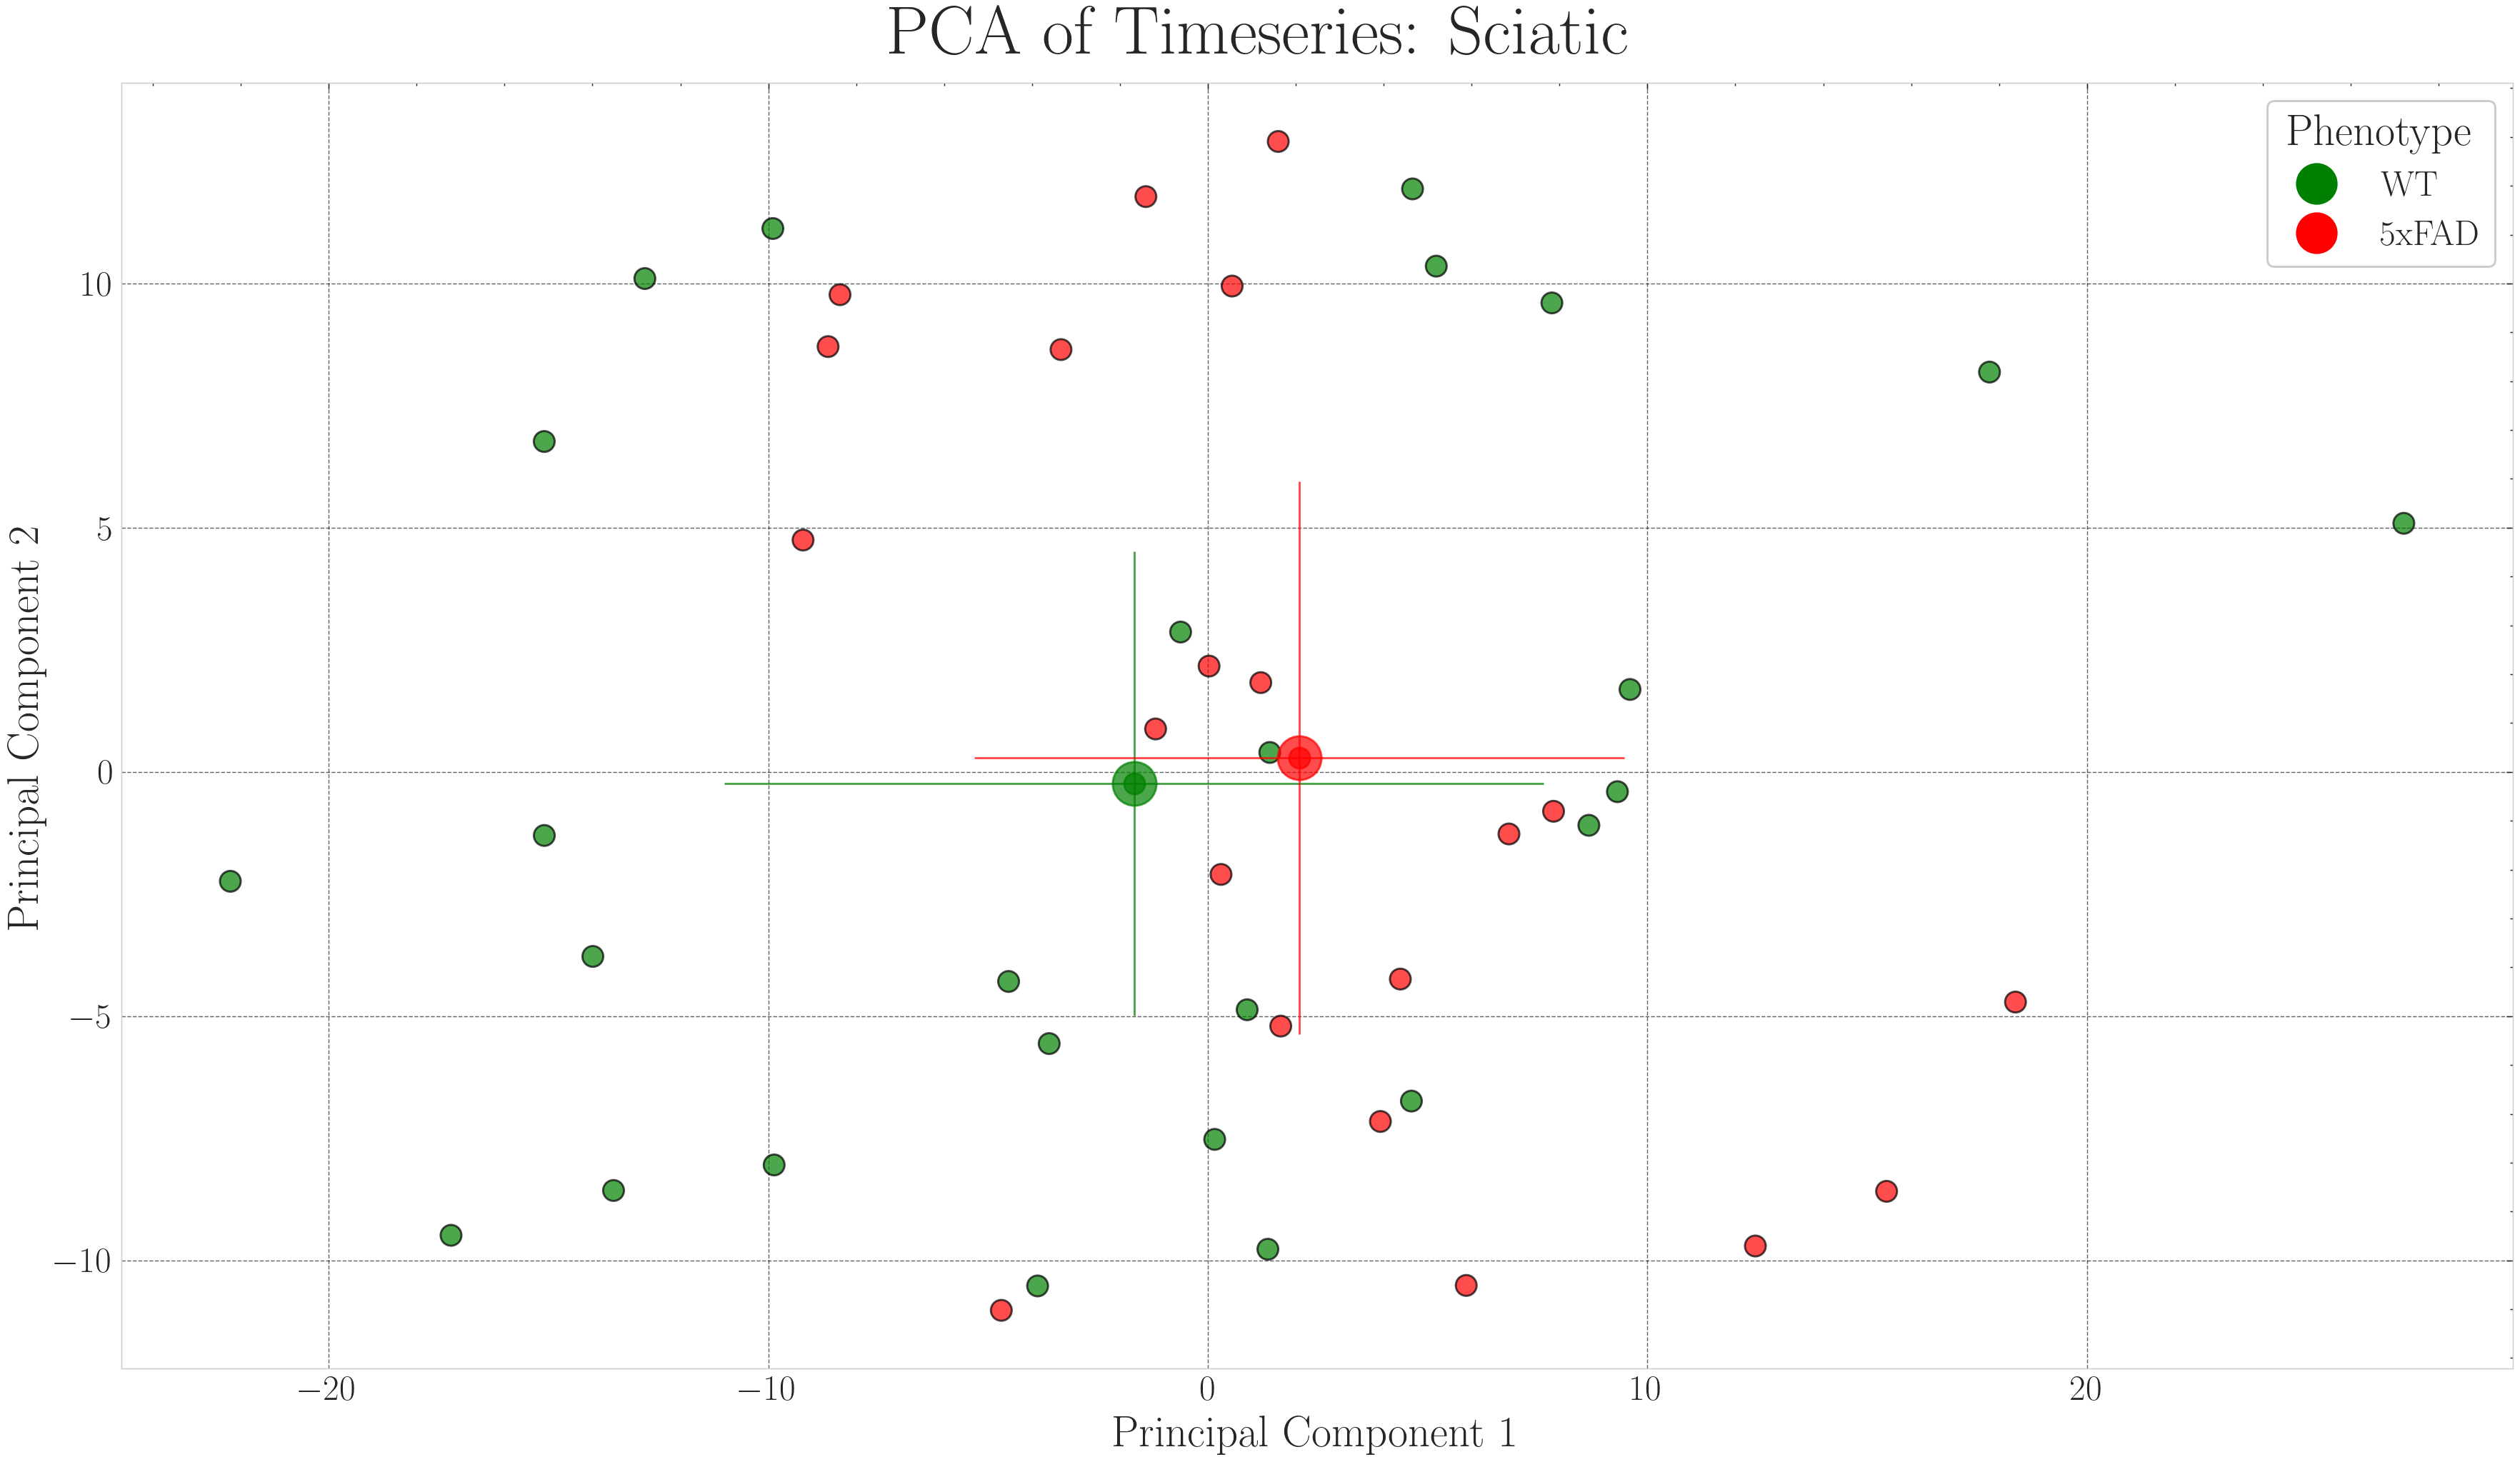


(Spine hump, Centroid Distance: 4.7288298432789215
(Spine hump, Average WT Spread PC1: 8.5755
(Spine hump, Average Mutant Spread PC1: 8.0432

(Spine hump, Average WT Spread PC2: 5.2904
(Spine hump, Average Mutant Spread PC2: 5.3241


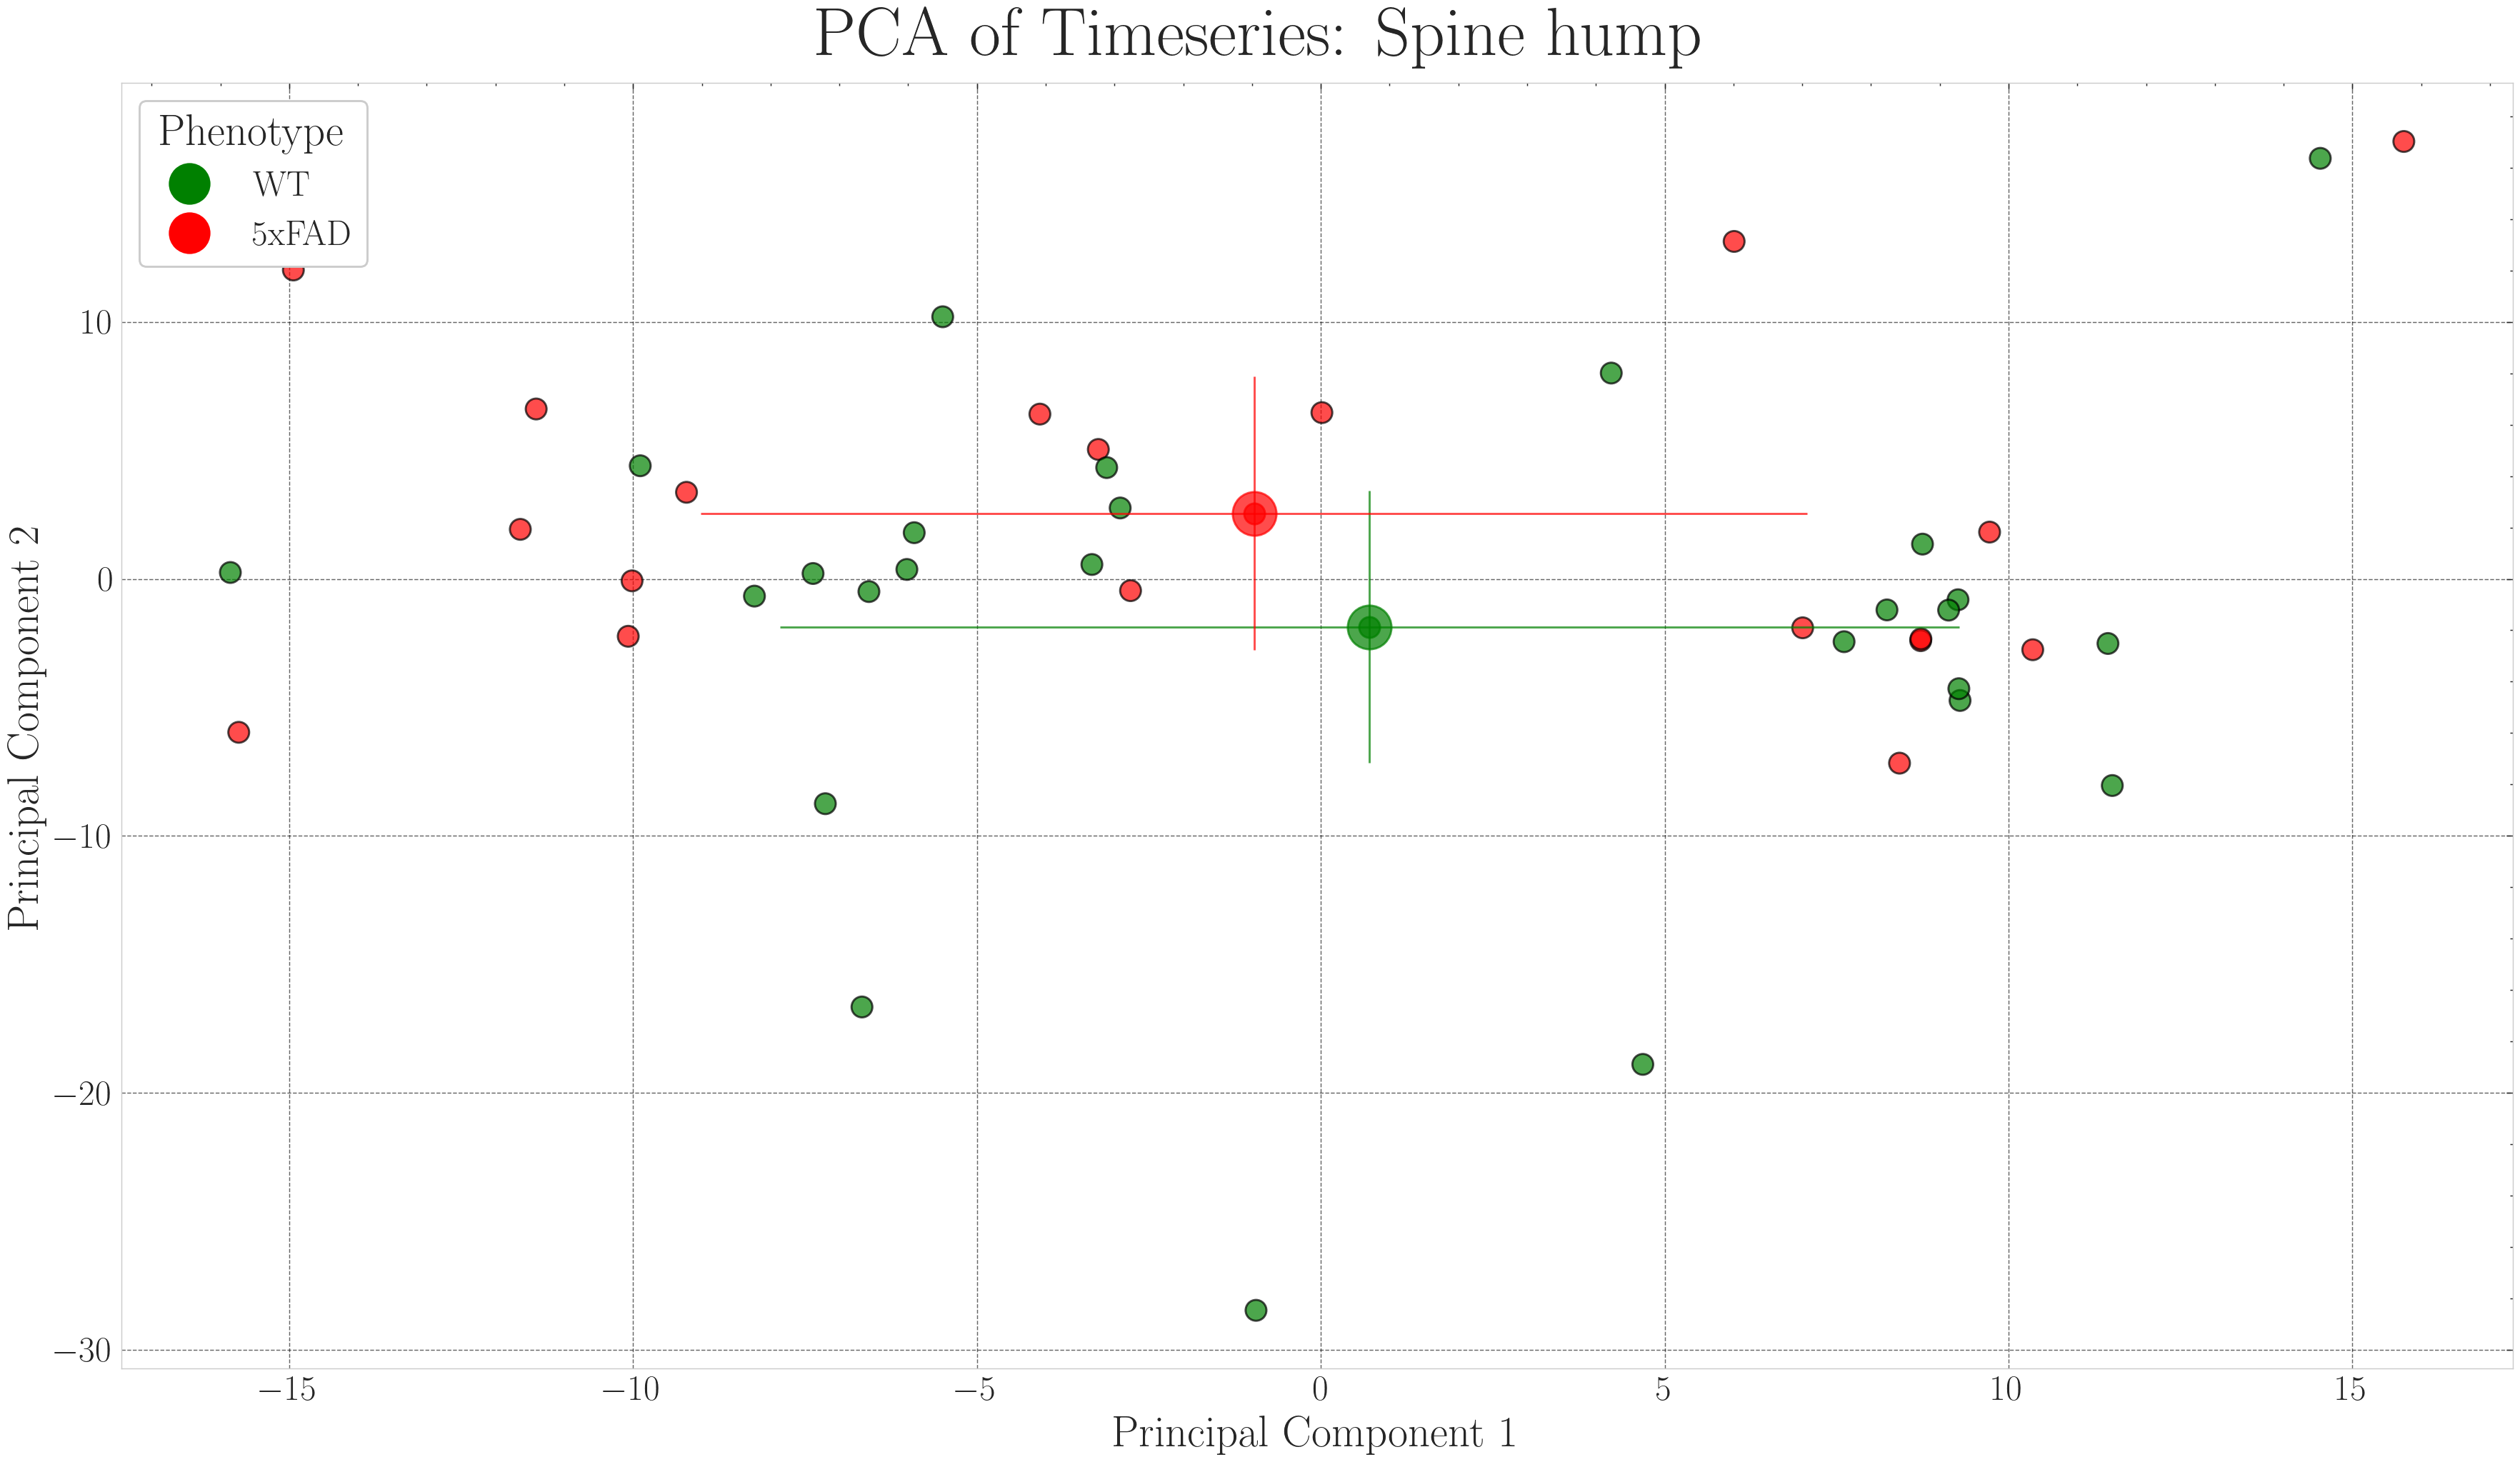

(<Figure size 3570x2100 with 1 Axes>,
 <Axes: xlabel='Principal Component 1', ylabel='Principal Component 2'>)

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def get_timeseries_pca(X, y, stim):

    stim_type = "Sciatic" if stim == "sciatic" else "Spine hump"

    n_channels = X.shape[1]
    
    X = X.reshape(X.shape[0], -1)

    fig, ax = plt.subplots(1, 1, figsize=(17, 10), dpi=210)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA for 2D visualization
    pca_plot = PCA(n_components=2, random_state=343)
    X_pca_plot = pca_plot.fit_transform(X_scaled)

    # Scatter plot
    ax.scatter(X_pca_plot[:, 0], X_pca_plot[:, 1], c=y, cmap=colors, edgecolor='k', s=100, alpha=0.7)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.grid(True, linestyle='--', alpha=0.6)

    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=21,
                          markerfacecolor=colors(i), label=phenotypes[i]) for i in phenotypes]
    ax.legend(handles=handles, title="Phenotype", fontsize=17, title_fontsize=21)

    # calculate centroids
    wt_centroid = np.array([X_pca_plot[y == 0].mean(axis=0)])
    mutant_centroid = np.array([X_pca_plot[y == 1].mean(axis=0)])
    
    ax.plot(wt_centroid[:, 0], wt_centroid[:, 1], 'o', color='green', markersize=21, label='WT Centroid', alpha = 0.7)
    ax.plot(mutant_centroid[:, 0], mutant_centroid[:, 1], 'o', color='red', markersize=21, label='Mutant Centroid', alpha = 0.7)

    # euclidean distance between centroids (for two groups)
    centroid_distance = np.linalg.norm(wt_centroid - mutant_centroid)
    print(f"\n({stim_type}, Centroid Distance:", centroid_distance)

    # Calculate average within-cluster standard deviation (spread)
    wt_std = [np.std(X_pca_plot[y == 0], axis=0).mean(), np.std(X_pca_plot[y == 0], axis=1).mean()]
    mutant_std = [np.std(X_pca_plot[y == 1], axis=0).mean(), np.std(X_pca_plot[y == 1], axis=1).mean()]

    ax.errorbar(wt_centroid[:, 0], wt_centroid[:, 1],
                         xerr=wt_std[0], yerr=wt_std[1],
                         fmt='o', color='green', markersize=10,
                         label='WT Centroid ± SD', alpha=0.7)

    ax.errorbar(mutant_centroid[:, 0], mutant_centroid[:, 1],
                 xerr=mutant_std[0], yerr=mutant_std[1],
                 fmt='o', color='red', markersize=10,
                 label='Mutant Centroid ± SD', alpha=0.7)

    print(f"({stim_type}, Average WT Spread PC1: {wt_std[0]:.4f}")
    print(f"({stim_type}, Average Mutant Spread PC1: {mutant_std[0]:.4f}\n")
    
    print(f"({stim_type}, Average WT Spread PC2: {wt_std[1]:.4f}")
    print(f"({stim_type}, Average Mutant Spread PC2: {mutant_std[1]:.4f}")

    fig.suptitle(f'PCA of Timeseries: {stim_type}')
    plt.savefig(f'/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/graphs/2D timeseries PCA ({stim_type}).png')
    plt.tight_layout()
    plt.show()
    return fig, ax

get_timeseries_pca(X_sciatic, y_sciatic, 'sciatic')
get_timeseries_pca(X_spine, y_spine, 'spine_hump')



In [ ]:
y_numeric

## ML

In [184]:
X_sciatic.shape
X_sciatic_reshaped = X_sciatic.reshape(X_sciatic.shape[0], -1)

X_sciatic_reshaped.shape

(47, 300)

In [190]:
import xgboost
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score
import numpy as np

def xgboost_custom(stim_types):

    for i, stim_type in enumerate(stim_types):
        
        X = X_sciatic if stim_type == 'sciatic' else X_spine
        y = y_sciatic if stim_type == 'sciatic' else y_spine
        
        X = X.reshape(X.shape[0], -1)
        
        # train-test split with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=343
        )
        
        # define the XGBClassifier with GPU acceleration
        xgb_pipeline = xgboost.XGBClassifier(
            eval_metric="logloss",
        )
        
        # define correct parameter grid
        xgb_param_grid = {
            'n_estimators': [100, 300, 500],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 1.0],
            'colsample_bytree': [0.7, 1.0],
            'gamma': [0, 0.1, 0.2],
            'reg_alpha': [0, 0.1, 1],  # L1 regularization
            'reg_lambda': [1, 10, 100]  # L2 regularization
        }
        
        # compute sample weights for class imbalance handling
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
        
        # randomized search for hyperparameter tuning
        xgb_random_search = RandomizedSearchCV(
            xgb_pipeline,
            xgb_param_grid,
            n_iter=20,  
            cv=5,
            scoring="precision",
            n_jobs=-1,
            verbose=1,
            random_state=343
        )
        
        # train the best XGBoost model with GPU acceleration & class balancing
        xgb_random_search.fit(
            X_train, y_train, sample_weight=sample_weights
        )
        
        # retrieve the best GPU-optimized model
        best_xgb = xgb_random_search.best_estimator_
        
        print(f"({stim_type}) Best Cross-Validation Precision:", xgb_random_search.best_score_)
        
        # evaluate on test set
        y_pred = best_xgb.predict(X_test)
        precision = precision_score(y_test, y_pred, zero_division=1)
        recall = recall_score(y_test, y_pred)

        print(f"({stim_type}) Test Precision: {precision:.4f}")
        print(f"({stim_type}) Test Recall: {recall:.4f}")

xgboost_custom(['sciatic', 'spine_hump'])



Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(sciatic) Best Cross-Validation Precision: 0.7333333333333333
(sciatic) Test Precision: 0.0000
(sciatic) Test Recall: 0.0000
Fitting 5 folds for each of 20 candidates, totalling 100 fits
(spine_hump) Best Cross-Validation Precision: 0.6799999999999999
(spine_hump) Test Precision: 0.6667
(spine_hump) Test Recall: 1.0000


## deep learning classifier

In [191]:
import torch
import torch.nn as nn

class TimeSeriesClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Input shape: (batch_size, 2, 700)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [192]:
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

# convert numpy arrays to PyTorch tensors
X_tensor = torch.FloatTensor(X_sciatic)
y_tensor = torch.FloatTensor(y_sciatic)

# create a dataset and split into train/validation sets
full_dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# define a time series augmentation transform
class TimeSeriesAugmentation:
    def __call__(self, x):
        # randomly add noise
        if np.random.rand() > 0.5:
            x = x + torch.randn_like(x) * 0.01
        # randomly perform a time shift
        if np.random.rand() > 0.5:
            shift = np.random.randint(-10, 10)
            x = torch.roll(x, shifts=shift, dims=-1)
        return x

# custom dataset that applies a transformation to the inputs
class TransformedDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.base_dataset[index]
        return self.transform(x), y

    def __len__(self):
        return len(self.base_dataset)

# wrap the training subset with the augmentation
train_dataset = TransformedDataset(train_subset, TimeSeriesAugmentation())

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
train_loader_augmented = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size)


In [193]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = TimeSeriesClassifier().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs (adjust based on your needs)
num_epochs = 50

best_val_loss = float('inf')

for epoch in range(num_epochs):
    # training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * inputs.size(0)

    # validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # calculate epoch statistics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        
print()

Epoch 1/50:
Train Loss: 0.7034 | Val Loss: 0.6943 | Val Acc: 0.5000
Epoch 2/50:
Train Loss: 0.6923 | Val Loss: 0.6963 | Val Acc: 0.4000
Epoch 3/50:
Train Loss: 0.6952 | Val Loss: 0.6980 | Val Acc: 0.5000
Epoch 4/50:
Train Loss: 0.6988 | Val Loss: 0.6996 | Val Acc: 0.5000
Epoch 5/50:
Train Loss: 0.6927 | Val Loss: 0.7013 | Val Acc: 0.5000
Epoch 6/50:
Train Loss: 0.6830 | Val Loss: 0.7059 | Val Acc: 0.5000
Epoch 7/50:
Train Loss: 0.6972 | Val Loss: 0.7104 | Val Acc: 0.5000
Epoch 8/50:
Train Loss: 0.6744 | Val Loss: 0.7137 | Val Acc: 0.5000
Epoch 9/50:
Train Loss: 0.6790 | Val Loss: 0.7151 | Val Acc: 0.5000
Epoch 10/50:
Train Loss: 0.6765 | Val Loss: 0.7167 | Val Acc: 0.5000
Epoch 11/50:
Train Loss: 0.7108 | Val Loss: 0.7165 | Val Acc: 0.5000
Epoch 12/50:
Train Loss: 0.6578 | Val Loss: 0.7153 | Val Acc: 0.5000
Epoch 13/50:
Train Loss: 0.6996 | Val Loss: 0.7147 | Val Acc: 0.5000
Epoch 14/50:
Train Loss: 0.6886 | Val Loss: 0.7126 | Val Acc: 0.5000
Epoch 15/50:
Train Loss: 0.6862 | Val Loss:

In [194]:
# load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Calculate metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
print(f"Final Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"F1 Score: {f1_score(all_labels, all_preds):.4f}")
print(f"ROC AUC: {roc_auc_score(all_labels, all_preds):.4f}")

Final Accuracy: 0.5000
F1 Score: 0.6667
ROC AUC: 0.5000
